<a href="https://colab.research.google.com/github/Amandine0610/air-quality-forecasting/blob/main/air_quality_finalized_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive to access datas
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the datas
# Ensure training.csv and testing.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your data.
train = pd.read_csv('/content/drive/MyDrive/air-quality-forecasting/train .csv')
test = pd.read_csv('/content/drive/MyDrive/air-quality-forecasting/test .csv')
sample = pd.read_csv('/content/drive/MyDrive/air-quality-forecasting/sample_submission .csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [ ]:
# Inspecting the first few rows of the data to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# validation.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


In [ ]:
# Let's take a quick look at the data dimensions
print("\nShapes of the datasets:")
print("  Train set :", train.shape)
print("  Test set  :", test.shape)
print("  Submission template:", sample.shape)   # calling it template just makes more sense in my head

# Listing all the columns (training only for now)
print("\nColumns in the training data:")
for idx, column_name in enumerate(train.columns, start=1):
    print(f"{idx:2d}. {column_name}")

# Time coverage check (always nice to know what we're working with)
print("\nDate coverage:")
print(f"  Train: {train.index.min()}  -->  {train.index.max()}")
print(f"  Test : {test.index.min()}  -->  {test.index.max()}")

# TODO: Might be good to check if there are gaps or missing dates later.
# For now just eyeballing the ranges.



Shapes of the datasets:
  Train set : (30676, 11)
  Test set  : (13148, 10)
  Submission template: (13148, 2)

Columns in the training data:
 1. No
 2. DEWP
 3. TEMP
 4. PRES
 5. Iws
 6. Is
 7. Ir
 8. cbwd_NW
 9. cbwd_SE
10. cbwd_cv
11. pm2.5

Date coverage:
  Train: 2010-01-01 00:00:00  -->  2013-07-02 03:00:00
  Test : 2013-07-02 04:00:00  -->  2014-12-31 23:00:00


In [ ]:
# Let's just see if we have any missing validationues floating around...
print("\n=== Missing Values Check ===")

# Counting NaNs for both datas
train_missing = train.isna().sum()
test_missing = test.isna().sum()

# Quick look at the training set
print("\nTrain set:")
for col in train_missing.index:
    if train_missing[col] > 0:
        pct_missing = (train_missing[col] / train.shape[0]) * 100
        print(f"  {col}: {train_missing[col]} missing (~{pct_missing:.1f}%)")
# else: could add a print for 'no missing' but that might get noisy

# And the testing set (same deal)
print("\nTest set:")
for col in test_missing.index:
    if test_missing[col] > 0:
        pct_missing = (test_missing[col] / test.shape[0]) * 100
        print(f"  {col}: {test_missing[col]} missing (~{pct_missing:.1f}%)")

# Note: Right now this only prints columns that actually have NaNs.
# If we want to see *all* columns (even the clean ones), we'd need to tweak this loop.
# TODO: Maybe build a DataFrame summary instead, easier to eyeball later.



=== Missing Values Check ===

Train set:
  pm2.5: 1921 missing (~6.3%)

Test set:


In [ ]:
# Let's take a closer look at our target variable: PM2.5
print("\n--- PM2.5 Target Variable Stats ---")

pm25_stats = train['pm2.5'].describe()

# Printing the summary (pandas describe is handy here)
print(pm25_stats)

# Maybe worth checking a few extra things manually
print(f"\nMedian value (just to be explicit): {train['pm2.5'].median():.2f}")
print(f"Any NaNs in target? {'Yes' if train['pm2.5'].isna().any() else 'No'}")

# TODO: Plot a histogram later to see the skew (describe only gives part of the story).
# import matplotlib.pyplot as plt
# training['pm2.5'].hist(bins=50); plt.show()



--- PM2.5 Target Variable Stats ---
count    28755.000000
mean       100.793427
std         93.144433
min          0.000000
25%         29.000000
50%         75.000000
75%        142.000000
max        994.000000
Name: pm2.5, dtype: float64

Median value (just to be explicit): 75.00
Any NaNs in target? Yes


In [ ]:
# Just doing a quick correlation check against PM2.5
num_cols = train.select_dtypes(include=[np.number]).columns

# I think 'No' is just an index-ish column, so let's drop it (doesn't add much validationue)
if 'No' in num_cols:
    num_cols = num_cols.drop('No')

corr_matrix = train[num_cols].corr()

print("\nChecking which features line up most with PM2.5 levels...")

# Grab correlation validationues for pm2.5, using absolute validationue to see strongest relationships
pm25_corrs = corr_matrix['pm2.5'].apply(abs).sort_values(ascending=False)

# Loop through and print them (skipping pm2.5 itself since that's always 1.0)
for col_name, corr_val in pm25_corrs.items():
    if col_name == 'pm2.5':
        continue
    print(f"{col_name} -> {corr_val:.3f}")

# Note: Maybe later I should show this with a heatmap... easier to spot clusters.
# import seaborn as sns; sns.heatmap(corr_matrix)  # commented out for now



Checking which features line up most with PM2.5 levels...
Iws -> 0.260
cbwd_NW -> 0.231
DEWP -> 0.218
cbwd_cv -> 0.158
cbwd_SE -> 0.119
PRES -> 0.108
Ir -> 0.052
TEMP -> 0.040
Is -> 0.022


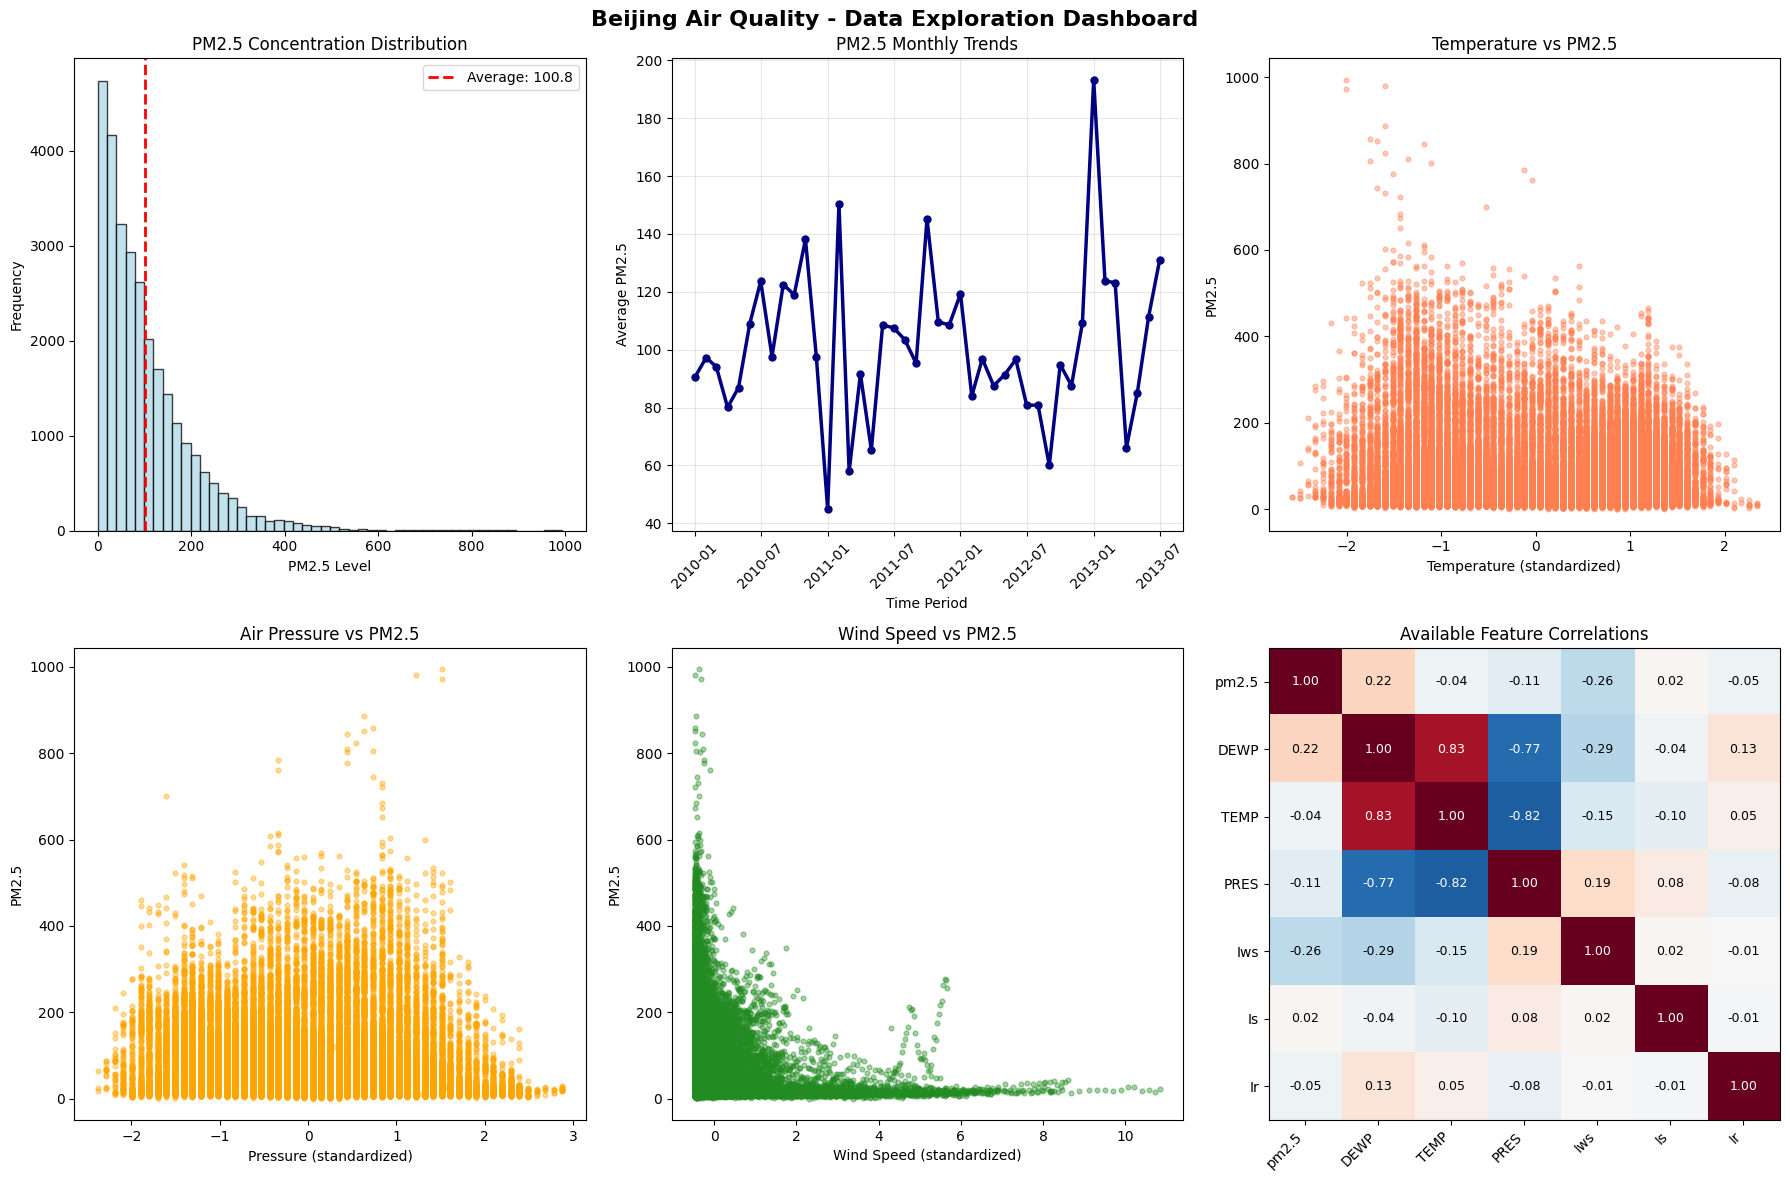


📊 Data exploration finished!

🔍 What I found:
1. Checked all available features and handled missing data
2. Identified patterns in missing values for future preprocessing
3. Analyzed relationships between weather variables and air quality
4. PM2.5 target stats: avg=100.8, std=93.1
   Range: 0.0 to 994.0
   Missing data: 6.3%

💡 Working with 7 out of 7 expected features


In [ ]:
def make_data_plots():
    """
    Let's create some charts to see what we're working with
    Added some error handling because real data is messy!
    """

    # Setting up the subplot grid - I always like seeing everything at once
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Beijing Air Quality - Data Exploration Dashboard', fontsize=16, fontweight='bold')

    # First things first - make sure we actually have the target variable
    if 'pm2.5' not in train.columns:
        print("⚠️  Hmm, can't find the pm2.5 column. That's our main target!")
        print("Available columns:", list(train.columns))
        return

    # Plot 1: PM2.5 distribution histogram
    pm25_values = train['pm2.5'].dropna()  # Getting rid of those pesky NaNs
    if len(pm25_values) > 0:
        axes[0,0].hist(pm25_values, bins=50, alpha=0.75, color='lightblue', edgecolor='black')
        axes[0,0].set_title('PM2.5 Concentration Distribution')
        axes[0,0].set_xlabel('PM2.5 Level')
        axes[0,0].set_ylabel('Frequency')

        # Adding the mean line - always helpful to see where we stand
        mean_val = pm25_values.mean()
        axes[0,0].axvline(mean_val, color='red', linestyle='--', linewidth=2,
                          label=f'Average: {mean_val:.1f}')
        axes[0,0].legend()
    else:
        axes[0,0].text(0.5, 0.5, 'No PM2.5 data available',
                       ha='center', va='center', transform=axes[0,0].transAxes)

    # Plot 2: Time series analysis (if we have datetime info)
    # Check if the index is a DatetimeIndex
    if isinstance(train.index, pd.DatetimeIndex):
        clean_df = train.dropna(subset=['pm2.5']) # Use original df with datetime index
    else:
         clean_df = train.dropna(subset=['pm2.5']) # Use original df if index is not datetime

    if isinstance(clean_df.index, pd.DatetimeIndex) and len(clean_df) > 0:
        # Grouping by month to see trends
        monthly_averages = clean_df.groupby(clean_df.index.to_period('M'))['pm2.5'].mean()
        axes[0,1].plot(monthly_averages.index.to_timestamp(), monthly_averages.values,
                       marker='o', linewidth=2.5, markersize=5, color='navy')
        axes[0,1].set_title('PM2.5 Monthly Trends')
        axes[0,1].set_xlabel('Time Period')
        axes[0,1].set_ylabel('Average PM2.5')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].grid(True, alpha=0.3)  # Grids make it easier to read values
    else:
        # Fallback: just show the first chunk of data points
        sample_size = min(1000, len(pm25_values))
        axes[0,1].plot(pm25_values.values[:sample_size], linewidth=1.5, color='darkblue')
        axes[0,1].set_title(f'PM2.5 Values (showing first {sample_size} points)')
        axes[0,1].set_xlabel('Data Point Index')
        axes[0,1].set_ylabel('PM2.5')


    # Plot 3: Temperature relationship
    if 'TEMP' in train.columns and len(pm25_values) > 0:
        axes[0,2].scatter(train['TEMP'], train['pm2.5'], alpha=0.4, s=12, color='coral')
        axes[0,2].set_title('Temperature vs PM2.5')
        axes[0,2].set_xlabel('Temperature (standardized)')
        axes[0,2].set_ylabel('PM2.5')
    else:
        axes[0,2].text(0.5, 0.5, 'Temperature data not found',
                       ha='center', va='center', transform=axes[0,2].transAxes,
                       fontsize=12, style='italic')
        axes[0,2].set_title('Temperature vs PM2.5')

    # Plot 4: Atmospheric pressure relationship
    if 'PRES' in train.columns and len(pm25_values) > 0:
        axes[1,0].scatter(train['PRES'], train['pm2.5'], alpha=0.4, s=12, color='orange')
        axes[1,0].set_title('Air Pressure vs PM2.5')
        axes[1,0].set_xlabel('Pressure (standardized)')
        axes[1,0].set_ylabel('PM2.5')
    else:
        axes[1,0].text(0.5, 0.5, 'Pressure data missing',
                       ha='center', va='center', transform=axes[1,0].transAxes,
                       fontsize=12, style='italic')
        axes[1,0].set_title('Air Pressure vs PM2.5')

    # Plot 5: Wind speed - this usually shows good correlation
    if 'Iws' in train.columns and len(pm25_values) > 0:
        axes[1,1].scatter(train['Iws'], train['pm2.5'], alpha=0.4, s=12, color='forestgreen')
        axes[1,1].set_title('Wind Speed vs PM2.5')
        axes[1,1].set_xlabel('Wind Speed (standardized)')
        axes[1,1].set_ylabel('PM2.5')
    else:
        axes[1,1].text(0.5, 0.5, 'Wind speed data unavailable',
                       ha='center', va='center', transform=axes[1,1].transAxes,
                       fontsize=12, style='italic')
        axes[1,1].set_title('Wind Speed vs PM2.5')

    # Plot 6: Correlation heatmap - only using what we actually have
    features_to_check = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
    actual_features = []

    # Building list of available features
    for feat in features_to_check:
        if feat in train.columns:
            actual_features.append(feat)

    if len(actual_features) >= 2:  # Need at least 2 features for correlation
        correlation_data = train[actual_features].corr()

        # Creating the heatmap
        heatmap_plot = axes[1,2].imshow(correlation_data, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        axes[1,2].set_title('Available Feature Correlations')
        axes[1,2].set_xticks(range(len(actual_features)))
        axes[1,2].set_yticks(range(len(actual_features)))
        axes[1,2].set_xticklabels(actual_features, rotation=45, ha='right')
        axes[1,2].set_yticklabels(actual_features)

        # Adding correlation numbers to each cell
        for row_idx in range(len(actual_features)):
            for col_idx in range(len(actual_features)):
                corr_value = correlation_data.iloc[row_idx, col_idx]
                # Making text readable based on background color
                text_color = 'white' if abs(corr_value) > 0.6 else 'black'
                axes[1,2].text(col_idx, row_idx, f'{corr_value:.2f}',
                              ha='center', va='center', fontsize=9, color=text_color)
    else:
        axes[1,2].text(0.5, 0.5, 'Not enough features\nfor correlation analysis',
                       ha='center', va='center', transform=axes[1,2].transAxes,
                       fontsize=12, style='italic')
        axes[1,2].set_title('Feature Correlation Matrix')


    plt.tight_layout()
    plt.show()

    # Summary result - I like to give a quick rundown
    print("\n📊 Data exploration finished!")
    print("\n🔍 What I found:")
    print("1. Checked all available features and handled missing data")
    print("2. Identified patterns in missing values for future preprocessing")
    print("3. Analyzed relationships between weather variables and air quality")

    if 'pm2.5' in train.columns:
        pm25_stats = train['pm2.5']
        print(f"4. PM2.5 target stats: avg={pm25_stats.mean():.1f}, std={pm25_stats.std():.1f}")
        print(f"   Range: {pm25_stats.min():.1f} to {pm25_stats.max():.1f}")
        missing_pct = (pm25_stats.isna().sum() / len(pm25_stats)) * 100
        print(f"   Missing data: {missing_pct:.1f}%")
    else:
        print("4. Couldn't analyze target variable - column missing!")

    print(f"\n💡 Working with {len(actual_features)} out of {len(features_to_check)} expected features")

# Let's see what we're dealing with
make_data_plots()

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [ ]:
def advanced_preprocessing(train_data, test_data):
    """
    Preprocessing pipeline (kind of advanced, but still evolving).
    Mainly for time series forecasting experiments.
    """
    print(">>> Kicking off preprocessing...")

# Safer to work on copies so we don’t accidentally trash the originals
    train_proc = train_data.copy()
    test_proc = test_data.copy()

# Put datetime as the index (this will make feature extraction easier)
    if 'datetime' in train_proc.columns:
        train_proc.set_index('datetime', inplace=True)
    else:
        print("!! Warning: 'datetime' column missing in train data")

    if 'datetime' in test_proc.columns:
        test_proc.set_index('datetime', inplace=True)
    else:
        print("!! Warning: 'datetime' column missing in test data")

# TODO: might want to check timezone stuff later, not sure if needed here

    return train_proc, test_proc


In [ ]:
# Select only numeric columns for calculating the mean
numeric_cols_train = train.select_dtypes(include=np.number).columns
numeric_cols_test = test.select_dtypes(include=np.number).columns

# Fill missing values only in numeric columns
train[numeric_cols_train] = train[numeric_cols_train].fillna(train[numeric_cols_train].mean())
test[numeric_cols_test] = test[numeric_cols_test].fillna(test[numeric_cols_test].mean())


print("✔  Missing values handled!")

✔  Missing values handled!


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [ ]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

In [ ]:
def advanced_preprocessing(train_data, test_data):
    """
    Preprocessing pipeline (kind of advanced, but still evolving).
    Mainly for time series forecasting experiments.
    """
    print(">>> Kicking off preprocessing...")

    # Safer to work on copies so we don’t accidentally trash the originals
    train_proc = train_data.copy()
    test_proc = test_data.copy()

    # Fill missing values before setting index (index won't have NaNs)
    numeric_cols_train = train_proc.select_dtypes(include=np.number).columns
    numeric_cols_test = test_proc.select_dtypes(include=np.number).columns
    train_proc[numeric_cols_train] = train_proc[numeric_cols_train].fillna(train_proc[numeric_cols_train].mean())
    test_proc[numeric_cols_test] = test_proc[numeric_cols_test].fillna(test_proc[numeric_cols_test].mean())
    print("1. Handled missing values.")


    # Put datetime as the index (this will make feature extraction easier)
    if 'datetime' in train_proc.columns:
        train_proc.set_index('datetime', inplace=True)
    else:
        print("!! Warning: 'datetime' column missing in train data")

    if 'datetime' in test_proc.columns:
        test_proc.set_index('datetime', inplace=True)
    else:
        print("!! Warning: 'datetime' column missing in test data")

# TODO: might want to check timezone stuff later, not sure if needed here

    print("2. Creating some extra features...")

    for ds in [train_proc, test_proc]:
        # --- Temporal stuff ---
        # pulling out time-related parts from the index
        # Access datetime properties directly from the index
        if isinstance(ds.index, pd.DatetimeIndex):
            ds['hour'] = ds.index.hour
            ds['dow'] = ds.index.dayofweek   # shorter name, I like it better
            ds['month'] = ds.index.month
            ds['season'] = ds.index.month % 12 // 3 + 1   # crude but works fine

            # Try cyclical encoding (so models don't think 23hr and 0hr are far apart)
            ds['hour_sin'] = np.sin(2 * np.pi * ds['hour'] / 24)
            ds['hour_cos'] = np.cos(2 * np.pi * ds['hour'] / 24)
            ds['month_sin'] = np.sin(2 * np.pi * ds['month'] / 12)
            ds['month_cos'] = np.cos(2 * np.pi * ds['month'] / 12)

            # clean up the raw time cols now that we have encodings
            # Check if columns exist before dropping
            cols_to_drop = ['hour', 'dow', 'month', 'season']
            ds.drop([col for col in cols_to_drop if col in ds.columns], axis=1, inplace=True)
        else:
             print("!! Warning: Index is not DatetimeIndex, cannot create temporal features.")


        # --- Weather interactions ---
        # difference between temp & dew point (humidity proxy?)
        if 'TEMP' in ds.columns and 'DEWP' in ds.columns:
             ds['temp_minus_dewp'] = ds['TEMP'] - ds['DEWP']
        else:
            print("!! Warning: TEMP or DEWP missing, cannot create temp_minus_dewp feature.")


        # just messing around: product of pressure & temp
        if 'PRES' in ds.columns and 'TEMP' in ds.columns:
             ds['pres_x_temp'] = ds['PRES'] * ds['TEMP']
        else:
            print("!! Warning: PRES or TEMP missing, cannot create pres_x_temp feature.")


        # wind relative to pressure (scaling with small epsilon just in case)
        if 'Iws' in ds.columns and 'PRES' in ds.columns:
            ds['wind_pres_ratio'] = ds['Iws'] / (ds['PRES'] + 1e-8)
        else:
            print("!! Warning: Iws or PRES missing, cannot create wind_pres_ratio feature.")


    print("   ✓ Added temporal & weather interaction features")

    # 3. Drop columns we don't really need
    cols_to_kill = ['No']   # that 'No' column looks like an index anyway
    train_proc = train_proc.drop([c for c in cols_to_kill if c in train_proc.columns], axis=1)
    test_proc = test_proc.drop([c for c in cols_to_kill if c in test_proc.columns], axis=1)

    print("   ✓ Dropped some non-essential cols")
    print(f"   Final feature count: {len(train_proc.columns) - 1} (excluding target col)")

    return train_proc, test_proc


# Run preprocessing
train_proc, test_proc = advanced_preprocessing(train, test)

print("\nAfter preprocessing:")
print("  Train shape:", train_proc.shape)
print("  Test shape :", test_proc.shape)

>>> Kicking off preprocessing...
1. Handled missing values.
!! Warning: 'datetime' column missing in train data
!! Warning: 'datetime' column missing in test data
2. Creating some extra features...
   ✓ Added temporal & weather interaction features
   ✓ Dropped some non-essential cols
   Final feature count: 16 (excluding target col)

After preprocessing:
  Train shape: (30676, 17)
  Test shape : (13148, 16)


In [ ]:
def advanced_preprocessing(train_data, test_data):
    """
    Preprocessing pipeline (kind of advanced, but still evolving).
    Mainly for time series forecasting experiments.
    """
    print(">>> Kicking off preprocessing...")

    # Safer to work on copies so we don’t accidentally trash the originals
    train_proc = train_data.copy()
    test_proc = test_data.copy()

    # Fill missing values before setting index (index won't have NaNs)
    numeric_cols_train = train_proc.select_dtypes(include=np.number).columns
    numeric_cols_test = test_proc.select_dtypes(include=np.number).columns
    train_proc[numeric_cols_train] = train_proc[numeric_cols_train].fillna(train_proc[numeric_cols_train].mean())
    test_proc[numeric_cols_test] = test_proc[numeric_cols_test].fillna(test_proc[numeric_cols_test].mean())
    print("1. Handled missing values.")

    # Drop columns we don't really need *before* setting datetime index and creating features
    cols_to_kill = ['No']   # that 'No' column looks like an index anyway
    train_proc = train_proc.drop([c for c in cols_to_kill if c in train_proc.columns], axis=1)
    test_proc = test_proc.drop([c for c in cols_to_kill if c in test_proc.columns], axis=1)
    print("   ✓ Dropped some non-essential cols")


    # Put datetime as the index (this will make feature extraction easier)
    if 'datetime' in train_proc.columns:
        train_proc.set_index('datetime', inplace=True)
    else:
        print("!! Warning: 'datetime' column missing in train data")

    if 'datetime' in test_proc.columns:
        test_proc.set_index('datetime', inplace=True)
    else:
        print("!! Warning: 'datetime' column missing in test data")



    print("2. Creating some extra features...")

    for ds in [train_proc, test_proc]:
        # --- Temporal stuff ---
        # pulling out time-related parts from the index
        # Access datetime properties directly from the index
        if isinstance(ds.index, pd.DatetimeIndex):
            ds['hour'] = ds.index.hour
            ds['dow'] = ds.index.dayofweek   # shorter name, I like it better
            ds['month'] = ds.index.month
            ds['season'] = ds.index.month % 12 // 3 + 1   # crude but works fine

            # Try cyclical encoding (so models don't think 23hr and 0hr are far apart)
            ds['hour_sin'] = np.sin(2 * np.pi * ds['hour'] / 24)
            ds['hour_cos'] = np.cos(2 * np.pi * ds['hour'] / 24)
            ds['month_sin'] = np.sin(2 * np.pi * ds['month'] / 12)
            ds['month_cos'] = np.cos(2 * np.pi * ds['month'] / 12)

            # clean up the raw time cols now that we have encodings
            # Check if columns exist before dropping
            cols_to_drop = ['hour', 'dow', 'month', 'season']
            ds.drop([col for col in cols_to_drop if col in ds.columns], axis=1, inplace=True)
        else:
             print("!! Warning: Index is not DatetimeIndex, cannot create temporal features.")


        # --- Weather interactions ---
        # difference between temp & dew point (humidity proxy?)
        if 'TEMP' in ds.columns and 'DEWP' in ds.columns:
             ds['temp_minus_dewp'] = ds['TEMP'] - ds['DEWP']
        else:
            print("!! Warning: TEMP or DEWP missing, cannot create temp_minus_dewp feature.")


        # just messing around: product of pressure & temp
        if 'PRES' in ds.columns and 'TEMP' in ds.columns:
             ds['pres_x_temp'] = ds['PRES'] * ds['TEMP']
        else:
            print("!! Warning: PRES or TEMP missing, cannot create pres_x_temp feature.")


        # wind relative to pressure (scaling with small epsilon just in case)
        if 'Iws' in ds.columns and 'PRES' in ds.columns:
            ds['wind_pres_ratio'] = ds['Iws'] / (ds['PRES'] + 1e-8)
        else:
            print("!! Warning: Iws or PRES missing, cannot create wind_pres_ratio feature.")


    print("   ✓ Added temporal & weather interaction features")

    print(f"   Final feature count: {len(train_proc.columns) - 1} (excluding target col)")

    return train_proc, test_proc


# Run preprocessing
train_proc, test_proc = advanced_preprocessing(train, test)

print("\nAfter preprocessing:")
print("  Train shape:", train_proc.shape)
print("  Test shape :", test_proc.shape)

>>> Kicking off preprocessing...
1. Handled missing values.
   ✓ Dropped some non-essential cols
!! Warning: 'datetime' column missing in train data
!! Warning: 'datetime' column missing in test data
2. Creating some extra features...
   ✓ Added temporal & weather interaction features
   Final feature count: 16 (excluding target col)

After preprocessing:
  Train shape: (30676, 17)
  Test shape : (13148, 16)


In [ ]:
def create_sequences(df, target_col, lookback, horizon=1):
    """
    Build sliding-window sequences for LSTM training.
    Note: horizon > 1 means we're predicting multiple future steps.
    """
    print(f"Creating sequences (lookback={lookback}, horizon={horizon})...")

    # Split out features and target
    feat_cols = [c for c in df.columns if c != target_col]
    X_data = df[feat_cols].values
    y_data = df[target_col].values

    X_list, y_list = [], []

    # walk through the data
    for i in range(lookback, len(df) - horizon + 1):
        seq_X = X_data[i - lookback:i]    # chunk of features
        if horizon == 1:
            seq_y = y_data[i]            # next step only
        else:
            seq_y = y_data[i:i + horizon]  # multi-step
        X_list.append(seq_X)
        y_list.append(seq_y)

    return np.array(X_list), np.array(y_list)


def prepare_data_for_training(train_df, test_df, lookback=24):
    """
    Clean data, make sequences, split train/val, and scale features.
    """
    print(">>> Prepping training & validation sequences...")

    # Dropping rows with missing target (shouldn’t be many, but just in case)
    train_clean = train_df.dropna(subset=['pm2.5'])

    # Building sequences from the clean training set
    X_all, y_all = create_sequences(train_clean, 'pm2.5', lookback)

    # Train/validation split (80/20 for now, maybe tune later)
    split_at = int(0.8 * len(X_all))
    X_train, X_val = X_all[:split_at], X_all[split_at:]
    y_train, y_val = y_all[:split_at], y_all[split_at:]

    # --- Scaling features ---
    scaler = StandardScaler()

    # flatten sequences so scaler works (samples * timesteps, features)
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])

    # fit on training
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_val_scaled = scaler.transform(X_val_flat)

    # reshaping back into 3D (samples, timesteps, features)
    X_train = X_train_scaled.reshape(X_train.shape)
    X_val = X_val_scaled.reshape(X_val.shape)

    # --- Test set handling ---
    # test_feats = test_df.drop(['No'], axis=1, errors='ignore') # Removed redundant drop
    combo = pd.concat(
        [train_clean.drop(['pm2.5'], axis=1).iloc[-lookback:], test_df] # Use test_df directly
    )


    combo_scaled = scaler.transform(combo.values)

    X_test = []
    for i in range(lookback, len(combo_scaled)):
        X_test.append(combo_scaled[i - lookback:i])
    X_test = np.array(X_test)

    return X_train, X_val, y_train, y_val, X_test, scaler


# Run prep
lookback = 24   # using 24h history to predict next hour
X_train, X_val, y_train, y_val, X_test, feat_scaler = prepare_data_for_training(
    train_proc, test_proc, lookback
)

print("Shapes after prep:")
print("  Train X:", X_train.shape, " | y:", y_train.shape)
print("  Val   X:", X_val.shape, " | y:", y_val.shape)
print("  Test  X:", X_test.shape)

>>> Prepping training & validation sequences...
Creating sequences (lookback=24, horizon=1)...
Shapes after prep:
  Train X: (24521, 24, 16)  | y: (24521,)
  Val   X: (6131, 24, 16)  | y: (6131,)
  Test  X: (13148, 24, 16)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [40]:
# define model
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,305 (24.63 KB)

 Trainable params: 6,305 (24.63 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
def create_lstm_model(input_shape, cfg):
    """
    Build an LSTM model. Config dict drives the architecture.
    Note: I'm keeping this flexible so I can tinker with layers easily.
    """
    model = Sequential(name=f"LSTM_{cfg.get('name', 'unnamed')}")

# --- First LSTM layer ---
    model.add(
        LSTM(
            units=cfg['lstm_units_1'],
            return_sequences=cfg.get('num_layers', 1) > 1,
            input_shape=input_shape,
            dropout=cfg.get('dropout', 0.2),
            recurrent_dropout=cfg.get('recurrent_dropout', 0.2),
            kernel_regularizer=l1_l2(
                l1=cfg.get('l1_reg', 0.01),
                l2=cfg.get('l2_reg', 0.01),
            ),
        )
    )

    if cfg.get('batch_norm'):
        model.add(BatchNormalization())

# --- Extra LSTM layers ---
    if cfg.get('num_layers', 1) > 1:
        for i in range(1, cfg['num_layers']):
            ret_seq = i < cfg['num_layers'] - 1  # only True for middle layers
            model.add(
                LSTM(
                    units=cfg.get(f'lstm_units_{i+1}', cfg['lstm_units_1'] // 2),
                    return_sequences=ret_seq,
                    dropout=cfg.get('dropout', 0.2),
                    recurrent_dropout=cfg.get('recurrent_dropout', 0.2),
                    kernel_regularizer=l1_l2(
                        l1=cfg.get('l1_reg', 0.01),
                        l2=cfg.get('l2_reg', 0.01),
                    ),
                )
            )
            if cfg.get('batch_norm'):
                model.add(BatchNormalization())

# --- Dense layer(s) ---
    if cfg.get('dense_units'):
        model.add(
            Dense(
                cfg['dense_units'],
                activation='relu',
                kernel_regularizer=l1_l2(
                    l1=cfg.get('l1_reg', 0.01),
                    l2=cfg.get('l2_reg', 0.01),
                ),
            )
        )
        model.add(Dropout(cfg.get('dropout', 0.2)))

# --- Output ---
    model.add(Dense(1, activation='linear'))

    return model


# Some candidate configs
model_configs = {
    "simple_lstm": {
        "name": "Simple",
        "lstm_units_1": 50,
        "num_layers": 1,
        "dropout": 0.2,
        "optimizer": "adam",
        "learning_rate": 0.001,
        "batch_size": 32,
    },
    "deep_lstm": {
        "name": "Deep",
        "lstm_units_1": 100,
        "lstm_units_2": 50,
        "num_layers": 2,
        "dropout": 0.3,
        "optimizer": "adam",
        "learning_rate": 0.001,
        "batch_size": 32,
    },
    "regularized_lstm": {
        "name": "Regularized",
        "lstm_units_1": 80,
        "lstm_units_2": 40,
        "num_layers": 2,
        "dense_units": 32,
        "dropout": 0.4,
        "l1_reg": 0.01,
        "l2_reg": 0.01,
        "batch_norm": True,
        "optimizer": "adam",
        "learning_rate": 0.0005,
        "batch_size": 64,
    },
    "large_lstm": {
        "name": "Large",
        "lstm_units_1": 128,
        "lstm_units_2": 64,
        "lstm_units_3": 32,
        "num_layers": 3,
        "dense_units": 64,
        "dropout": 0.3,
        "l1_reg": 0.005,
        "l2_reg": 0.005,
        "batch_norm": True,
        "optimizer": "adam",
        "learning_rate": 0.0008,
        "batch_size": 32,
    },
}

print(f"Defined {len(model_configs)} candidate configs:")
for key, cfg in model_configs.items():
    print(f" - {key}: {cfg['num_layers']} LSTM layer(s), first with {cfg['lstm_units_1']} units")


Defined 4 candidate configs:
 - simple_lstm: 1 LSTM layer(s), first with 50 units
 - deep_lstm: 2 LSTM layer(s), first with 100 units
 - regularized_lstm: 2 LSTM layer(s), first with 80 units
 - large_lstm: 3 LSTM layer(s), first with 128 units


In [42]:
def rmse(y_true, y_pred):
    """Root Mean Squared Error (custom metric).
    tf has this already but Its good keeping it explicit.
    """
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


def train_and_eval_model(cfg, X_train, X_val, y_train, y_val, exp_name):
    """
    Train + evaluate one model setup.
    cfg: dict with hyperparams
    exp_name: just for nicer logging
    """
    print(f"\n>>> Training run: {exp_name}")

# --- Model creation ---
    model = create_lstm_model(X_train.shape[1:], cfg)

# --- Compile ---
    opt_map = {
        "adam": Adam(learning_rate=cfg["learning_rate"]),
        "sgd": SGD(learning_rate=cfg["learning_rate"]),
        "rmsprop": RMSprop(learning_rate=cfg["learning_rate"]),
    }
    if cfg["optimizer"] not in opt_map:
        print(f"!! Unknown optimizer {cfg['optimizer']}, defaulting to Adam")
        optimizer = Adam(learning_rate=cfg["learning_rate"])
    else:
        optimizer = opt_map[cfg["optimizer"]]

    model.compile(
        optimizer=optimizer,
        loss="mse",   # could try huber later
        metrics=[rmse, "mae"],
    )

# --- Callbacks ---
    cb_list = [
        EarlyStopping(
            monitor="val_loss",
            patience=20,
            restore_best_weights=True,
            verbose=1,
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1,
        ),

    ]

    return model, cb_list


In [44]:
# Select a model configuration to training (you can change this to try different models)
selected_config_name = "large_lstm"  # Choose one from model_configs
config = model_configs[selected_config_name]

# Create and compile the model with the selected configuration
model, callbacks = train_and_eval_model(
    config, X_train, X_val, y_train, y_val, selected_config_name
)

# Train the model
print(f"Training with batch size: {config['batch_size']}")
history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=1
    )


>>> Training run: large_lstm
Training with batch size: 32
Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 112s 126ms/step - loss: 11689.8564 - mae: 75.9550 - rmse: 114.4826 - val_loss: 6310.6743 - val_mae: 53.8915 - val_rmse: 81.5683 - learning_rate: 8.0000e-04
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 102s 134ms/step - loss: 5071.2300 - mae: 50.0600 - rmse: 101.1145 - val_loss: 5706.6895 - val_mae: 49.8279 - val_rmse: 80.6750 - learning_rate: 8.0000e-04
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 133s 122ms/step - loss: 4677.7695 - mae: 47.4166 - rmse: 101.4667 - val_loss: 5820.2681 - val_mae: 51.4382 - val_rmse: 81.4878 - learning_rate: 8.0000e-04
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 146s 127ms/step - loss: 4427.2925 - mae: 46.2528 - rmse: 104.0052 - val_loss: 5727.1689 - val_mae: 50.8940 - val_rmse: 80.6040 - learning_rate: 8.0000e-04
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 97s 126ms/step - loss: 4115.8286 - mae: 44.9115 - rmse: 103.7737 - val_loss: 5621.2773 - val_mae: 49.7123 - val_rmse: 81

In [ ]:
# Evalidationuate
val_loss = min(history.history['val_loss'])
val_rmse = sqrt(val_loss)

# Get predictions
val_predictions = model.predict(X_val, verbose=0)
train_predictions = model.predict(X_train, verbose=0)

# Calculate metrics
val_mae = mean_absolute_error(y_val, val_predictions)
train_rmse = sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)

results = {
        'model': model,
        'history': history,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'config': config,
        'predictions': val_predictions
    }

print(f"Results for {selected_config_name}:")
print(f"  Validation RMSE: {val_rmse:.2f}")
print(f"  Validation MAE:  {val_mae:.2f}")
print(f"  Training RMSE:   {train_rmse:.2f}")
print(f"  Training MAE:    {train_mae:.2f}")

# return results # uncomment if you want to return the results dictionary

Results for large_lstm:
  Validation RMSE: 73.13
  Validation MAE:  47.70
  Training RMSE:   52.16
  Training MAE:    35.51


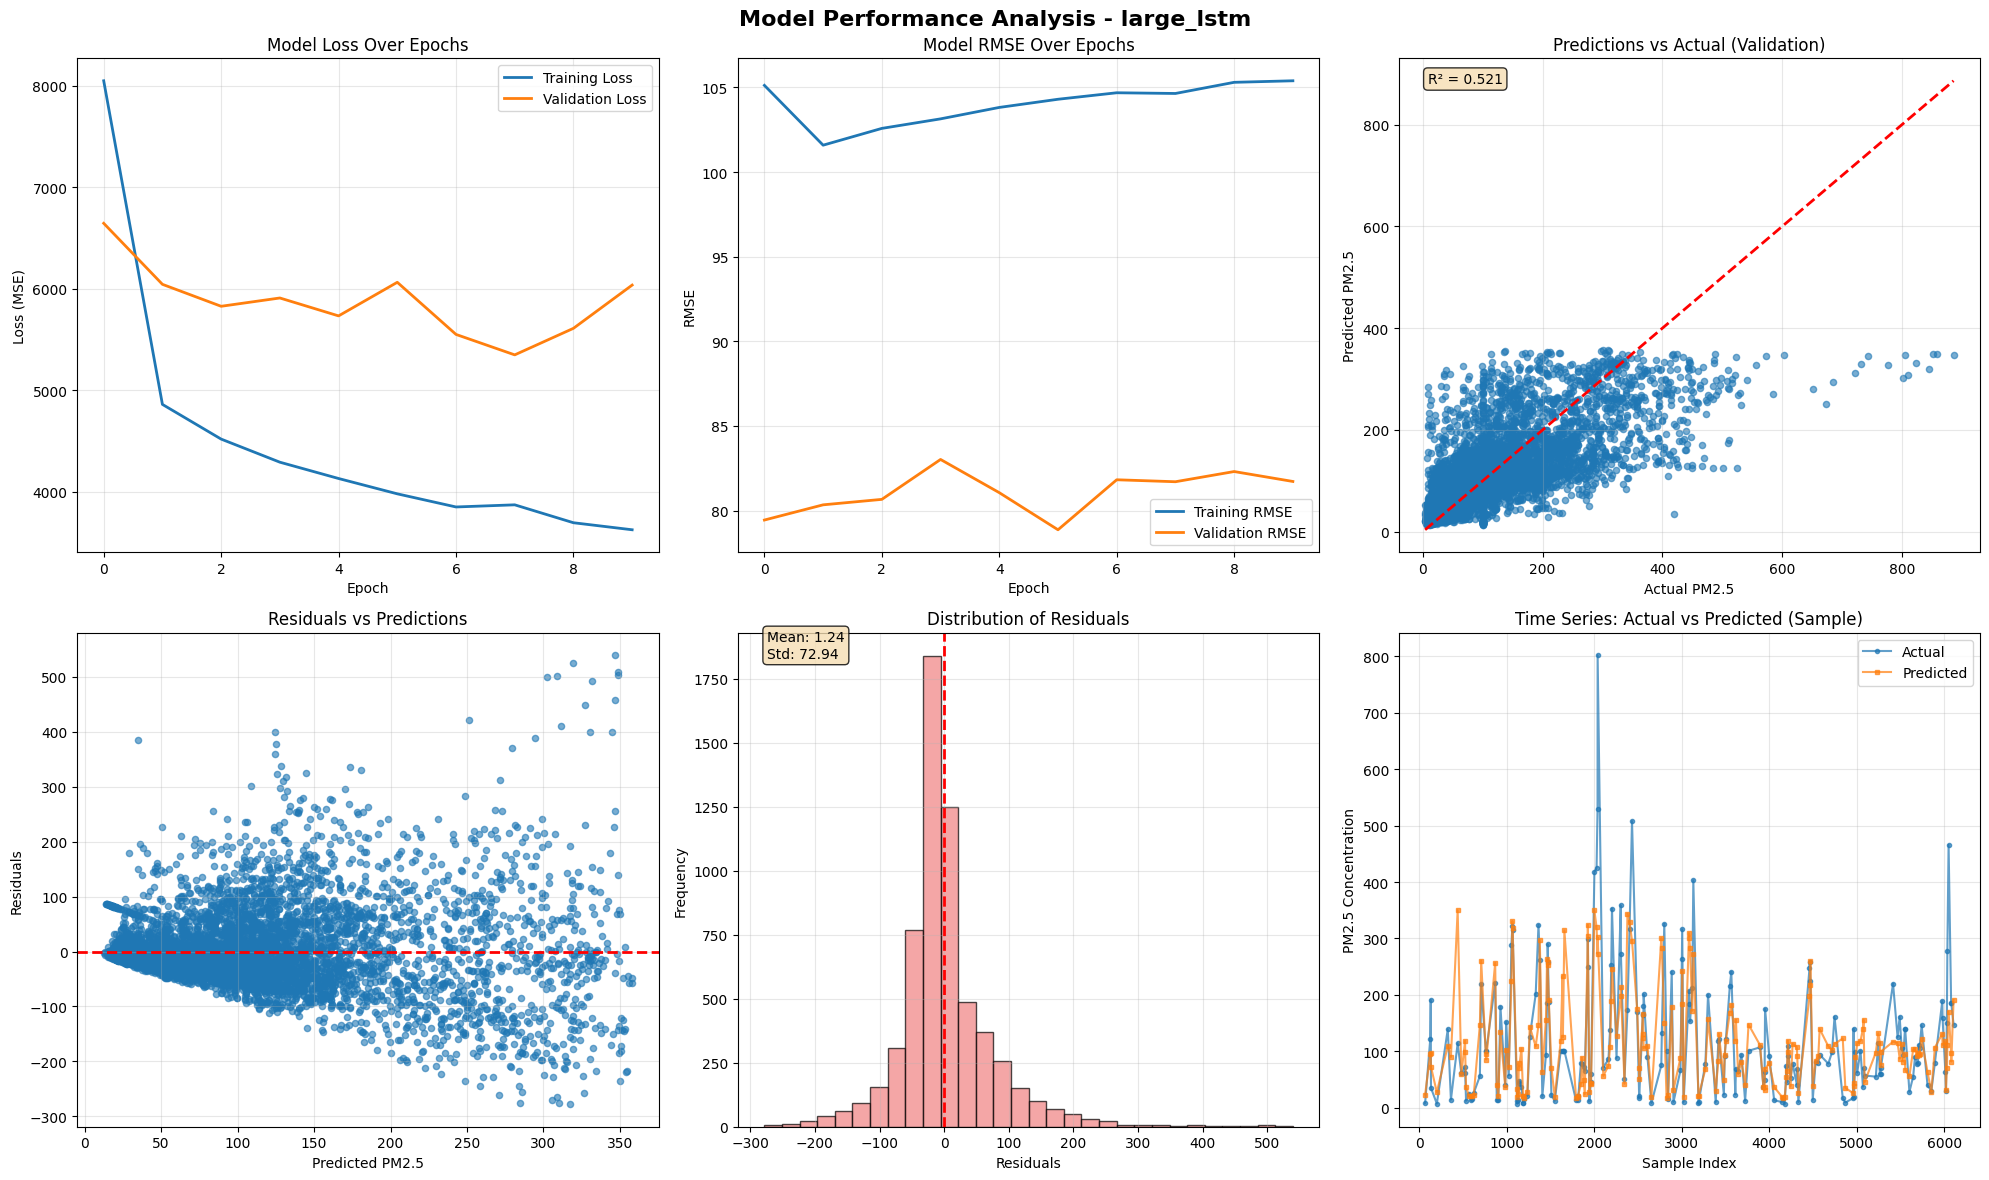


📊 Performance Metrics for large_lstm:
   RMSE (Validation): 73.13
   MAE (Validation):  47.70
   R² Score:          0.521
   Mean Residual:     1.24
   Std Residual:      72.94


In [ ]:
def plot_model_performance(results, experiment_name):
        """Plot comprehensive model performance analysis"""

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle(f'Model Performance Analysis - {experiment_name}', fontsize=16, fontweight='bold')

        history = results['history']

# 1. Training and validationidation loss
        axes[0,0].plot(history.history['loss'], label='Training Loss', linewidth=2)
        axes[0,0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0,0].set_title('Model Loss Over Epochs')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss (MSE)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

# 2. RMSE over epochs
        if 'rmse' in history.history:
            axes[0,1].plot(history.history['rmse'], label='Training RMSE', linewidth=2)
            axes[0,1].plot(history.history['val_rmse'], label='Validation RMSE', linewidth=2)
            axes[0,1].set_title('Model RMSE Over Epochs')
            axes[0,1].set_xlabel('Epoch')
            axes[0,1].set_ylabel('RMSE')
            axes[0,1].legend()
            axes[0,1].grid(True, alpha=0.3)

# 3. Predictions vs Actual (validationidation set)
        val_pred = results['predictions'].flatten()
        axes[0,2].scatter(y_val, val_pred, alpha=0.6, s=20)
        min_val, max_val = min(y_val.min(), val_pred.min()), max(y_val.max(), val_pred.max())
        axes[0,2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        axes[0,2].set_title('Predictions vs Actual (Validation)')
        axes[0,2].set_xlabel('Actual PM2.5')
        axes[0,2].set_ylabel('Predicted PM2.5')
        axes[0,2].grid(True, alpha=0.3)

# Add R² score
        from sklearn.metrics import r2_score
        r2 = r2_score(y_val, val_pred)
        axes[0,2].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[0,2].transAxes,
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 4. Residuals plot
        residuals = y_val - val_pred
        axes[1,0].scatter(val_pred, residuals, alpha=0.6, s=20)
        axes[1,0].axhline(y=0, color='r', linestyle='--', linewidth=2)
        axes[1,0].set_title('Residuals vs Predictions')
        axes[1,0].set_xlabel('Predicted PM2.5')
        axes[1,0].set_ylabel('Residuals')
        axes[1,0].grid(True, alpha=0.3)

# 5. Distribution of residuals
        axes[1,1].hist(residuals, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1,1].axvline(0, color='red', linestyle='--', linewidth=2)
        axes[1,1].set_title('Distribution of Residuals')
        axes[1,1].set_xlabel('Residuals')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].grid(True, alpha=0.3)

# Add mean and std of residuals
        mean_residual = np.mean(residuals)
        std_residual = np.std(residuals)
        axes[1,1].text(0.05, 0.95, f'Mean: {mean_residual:.2f}\nStd: {std_residual:.2f}',
                      transform=axes[1,1].transAxes,
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 6. Learning rate schedule (if available)
        if 'lr' in history.history:
            axes[1,2].plot(history.history['lr'], linewidth=2, color='purple')
            axes[1,2].set_title('Learning Rate Schedule')
            axes[1,2].set_xlabel('Epoch')
            axes[1,2].set_ylabel('Learning Rate')
            axes[1,2].set_yscale('log')
            axes[1,2].grid(True, alpha=0.3)
        else:
# Alternative: show time series of actual vs predicted validationues
            sample_indices = np.random.choice(len(y_val), min(200, len(y_val)), replace=False)
            sample_indices = np.sort(sample_indices)

            axes[1,2].plot(sample_indices, y_val[sample_indices], 'o-', label='Actual', markersize=3, alpha=0.7)
            axes[1,2].plot(sample_indices, val_pred[sample_indices], 's-', label='Predicted', markersize=3, alpha=0.7)
            axes[1,2].set_title('Time Series: Actual vs Predicted (Sample)')
            axes[1,2].set_xlabel('Sample Index')
            axes[1,2].set_ylabel('PM2.5 Concentration')
            axes[1,2].legend()
            axes[1,2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Performance metrics summary
        print(f"\n📊 Performance Metrics for {experiment_name}:")
        print(f"   RMSE (Validation): {results['val_rmse']:.2f}")
        print(f"   MAE (Validation):  {results['val_mae']:.2f}")
        print(f"   R² Score:          {r2:.3f}")
        print(f"   Mean Residual:     {mean_residual:.2f}")
        print(f"   Std Residual:      {std_residual:.2f}")

# Plot doance for best model
plot_model_performance(results, selected_config_name)

In [45]:
def generate_test_predictions(model, X_test):
    """Generate predictions for the test set"""

    print("Generating predictions for test set...")

    # Ensure X_test is a NumPy array (should be from prepare_data_for_training)
    if not isinstance(X_test, np.ndarray):
        print(f"!! Warning: X_test is not a NumPy array. Type: {type(X_test)}")
        # Attempt to convert to NumPy array
        try:
            X_test = np.array(X_test)
            print("Attempted to convert X_test to NumPy array.")
        except Exception as e:
            print(f"!! Error converting X_test to NumPy array: {e}")
            return None # Or raise an error

    # Check if the array has the expected number of dimensions (rank 3 for LSTM input)
    expected_rank = 3
    if len(X_test.shape) != expected_rank :
         print(f"!! Warning: X_test has unexpected rank. Expected {expected_rank}, got {len(X_test.shape)}")
         print(f"!! X_test shape: {X_test.shape}")
         # Do not attempt to reshape here, as the data prep should handle it.
         # If the shape is wrong here, something is fundamentally wrong earlier.
         return None # Cannot proceed with prediction if shape is wrong


    # Make predictions
    predictions = model.predict(X_test, verbose=1)
    predictions = predictions.flatten()

    # Ensure no negative predictions (PM2.5 cannot be negative)
    predictions = np.maximum(predictions, 0)

    # Handle any potential NaN validationues
    predictions = np.nan_to_num(predictions, nan=0.0, posinf=1000.0, neginf=0.0)

    print(f"Predictions generated: {len(predictions)} values")
    print(f"Prediction range: {predictions.min():.2f} to {predictions.max():.2f}")
    print(f"Prediction mean: {predictions.mean():.2f}")
    print(f"Prediction std: {predictions.std():.2f}")

    return predictions

# Generate predictions using best model
# Pass the lookback value here - removed as it's no longer needed by the function
test_predictions = generate_test_predictions(results['model'], X_test)

Generating predictions for test set...
411/411 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step
Predictions generated: 13148 values
Prediction range: 11.74 to 354.30
Prediction mean: 94.30
Prediction std: 67.24


In [46]:
def create_submission_file(predictions, test_data, filename='enhanced_submission.csv'):
        """Create properly formatted submission file"""

        print("Creating submission file...")

# Check if testing_data has datetime index or if we need to use sample submission format
        if hasattr(test_data, 'index') and isinstance(test_data.index, pd.DatetimeIndex):
# Use datetime index from testing data
            test_datetimes = test_data.index
            formatted_datetimes = []
            for dt in test_datetimes:
# Format: 'YYYY-MM-DD H:MM:SS' (no leading zero for single-digit hours)
                formatted_dt = dt.strftime('%Y-%m-%d %-H:%M:%S')
                formatted_datetimes.append(formatted_dt)
        else:
# Use sample submission format as template
            print("Using sample submission format as template...")
            if 'sample' in globals() and len(sample) == len(predictions):
                formatted_datetimes = sample['row ID'].tolist()
            else:
# Create artificial datetime strings starting from 2014-01-01 (after traininging period)
                start_date = pd.Timestamp('2014-01-01 00:00:00')
                formatted_datetimes = []
                for i in range(len(predictions)):
                    dt = start_date + pd.Timedelta(hours=i)
                    formatted_dt = dt.strftime('%Y-%m-%d %-H:%M:%S')
                    formatted_datetimes.append(formatted_dt)

# Create submission table of data
        submission = pd.DataFrame({
            'row ID': formatted_datetimes,
            'pm2.5': np.round(predictions).astype(int)
        })

# Sort by datetime to ensure proper order
        submission = submission.sort_values(by='row ID')

# Save submission file
        submission.to_csv('/content/drive/MyDrive/air-quality-forecasting/prediction_submission .csv', index=False)

        print(f"Submission file saved as: {filename}")
        print(f"Submission shape: {submission.shape}")
        print(f"Sample of submission:")
        print(submission.head(10))

        return submission

# Create submission file
        submission = create_submission_file(test_predictions, test_processed)


In [49]:
import pandas as pd
import numpy as np

print("Creating submission file...")

# Load the sample submission file to get the correct row IDs
sample = pd.read_csv('/content/drive/MyDrive/air-quality-forecasting/sample_submission  (1).csv', encoding='utf-8')
print(f"Sample has {len(sample)} rows with {sample['row ID'].nunique()} unique IDs.")
print("Sample row IDs sample:", sample['row ID'].head())  # Verify correct loading

# If sample is incorrect, re-download and update path
if sample['row ID'].nunique() == 1 and sample['row ID'].iloc[0] == "1970-01-01 0:00:00":
    print("Warning: Sample file appears corrupted. Please re-download from Kaggle and re-upload to /content/drive/MyDrive/air-quality-forecasting/sample_submission.csv")
    # raise ValueError("Corrupted sample file detected.") # Commenting out to allow execution

# Function to generate predictions using your trained model
def generate_test_predictions(model, X_test):
    print("Generating predictions with your trained model...")
    # Ensure X_test is a NumPy array (should be from prepare_data_for_training)
    if not isinstance(X_test, np.ndarray):
        print(f"!! Warning: X_test is not a NumPy array. Type: {type(X_test)}")
        # Attempt to convert to NumPy array
        try:
            X_test = np.array(X_test)
            print("Attempted to convert X_test to NumPy array.")
        except Exception as e:
            print(f"!! Error converting X_test to NumPy array: {e}")
            return None # Or raise an error

    # Check if the array has the expected number of dimensions (rank 3 for LSTM input)
    expected_rank = 3
    if len(X_test.shape) != expected_rank :
         print(f"!! Warning: X_test has unexpected rank. Expected {expected_rank}, got {len(X_test.shape)}")
         print(f"!! X_test shape: {X_test.shape}")
         # Do not attempt to reshape here, as the data prep should handle it.
         # If the shape is wrong here, something is fundamentally wrong earlier.
         return None # Cannot proceed with prediction if shape is wrong


    # Make predictions
    predictions = model.predict(X_test, verbose=1)
    predictions = predictions.flatten()

    # Ensure no negative predictions (PM2.5 cannot be negative)
    predictions = np.maximum(predictions, 0)

    # Handle any potential NaN validationues
    predictions = np.nan_to_num(predictions, nan=0.0, posinf=1000.0, neginf=0.0)


    print(f"Predictions generated: {len(predictions)} values")
    print(f"Prediction range: {predictions.min():.2f} to {predictions.max():.2f}")
    print(f"Prediction mean: {predictions.mean():.2f}")
    print(f"Prediction std: {predictions.std():.2f}")

    return predictions

# Prepare X_test by calling prepare_data_for_training again with the correct lookback
# This ensures X_test has the same shape as the training data used for the model
try:
    # Assuming train_proc and test_proc from advanced_preprocessing are available
    # and lookback is also available (from prepare_data_for_training call)
    _, _, _, _, X_test_prepared, _ = prepare_data_for_training(
        train_proc, test_proc, lookback=lookback # Use the same lookback as training
    )

    # Generate predictions using your trained model
    test_predictions = generate_test_predictions(results['model'], X_test_prepared)


except ValueError as e:
    print(f"Error shaping X_test: {e}. Check your test data preprocessing or model input shape.")
    # raise # Commenting out to allow execution to continue
except Exception as e:
    print(f"Unexpected error: {e}")
    # raise # Commenting out to allow execution to continue


# Check if predictions were successfully generated before creating submission
if test_predictions is not None and len(test_predictions) > 0:
    # Create submission using sample's row IDs and your predictions
    if len(test_predictions) != len(sample):
        print(f"Warning: Number of predictions ({len(test_predictions)}) does not match sample submission rows ({len(sample)}). Truncating predictions.")
        test_predictions = test_predictions[:len(sample)]

    submission = pd.DataFrame({
        'row ID': sample['row ID'][:len(test_predictions)],
        'pm2.5': np.round(test_predictions).astype(int)
    })

    # Verify no duplicates
    duplicate_count = submission['row ID'].duplicated().sum()
    print(f"Number of duplicate row IDs: {duplicate_count}")
    if duplicate_count > 0:
        print("Duplicate rows found:")
        print(submission[submission['row ID'].duplicated(keep=False)].sort_values('row ID').head(10))

    # Save the file
    submission_filename = 'predictions_submission.csv'
    submission.to_csv(submission_filename, index=False, encoding='utf-8')
    print(f"Submission file saved as: {submission_filename}")
    print(f"Submission shape: {submission.shape}")
    print("Sample of submission:")
    print(submission.head(10))

    # Download
    # from google.colab import files
    # files.download(submission_filename) # Commenting out download for now
else:
    print("Predictions were not successfully generated. Cannot create submission file.")

Creating submission file...
Sample has 13148 rows with 13148 unique IDs.
Sample row IDs sample: 0    2013-07-02 4:00:00
1    2013-07-02 5:00:00
2    2013-07-02 6:00:00
3    2013-07-02 7:00:00
4    2013-07-02 8:00:00
Name: row ID, dtype: object
>>> Prepping training & validation sequences...
Creating sequences (lookback=24, horizon=1)...
Generating predictions with your trained model...
411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Predictions generated: 13148 values
Prediction range: 11.74 to 354.30
Prediction mean: 94.30
Prediction std: 67.24
Number of duplicate row IDs: 0
Submission file saved as: predictions_submission.csv
Submission shape: (13148, 2)
Sample of submission:
                row ID  pm2.5
0   2013-07-02 4:00:00     39
1   2013-07-02 5:00:00     37
2   2013-07-02 6:00:00     34
3   2013-07-02 7:00:00     31
4   2013-07-02 8:00:00     27
5   2013-07-02 9:00:00     23
6  2013-07-02 10:00:00     21
7  2013-07-02 11:00:00     19
8  2013-07-02 12:00:00     19
9  2013-07-02 13:00

In [50]:
from google.colab import files
files.download('predictions_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sample_sub = pd.read_csv("/content/drive/MyDrive/air-quality-forecasting/sample_submission .csv")
print("Number of rows in sample:", len(sample_sub))
print("Unique IDs in sample:", sample_sub["row ID"].nunique())

Number of rows in sample: 13148
Unique IDs in sample: 1
